In [ ]:
!pip install utm
!pip install geopandas
!pip install contextily

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from io import StringIO 
from glob import glob 
import pandas as pd 
import torch 
import numpy as np 
import utm 
import torchvision 
from PIL import Image 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline 

sf_train_folder = "/content/drive/MyDrive/sf-xs-1/small/train"
sf_testdb_folder = '/content/drive/MyDrive/sf-xs-1/small/test/database'
sf_testque_folder = '/content/drive/MyDrive/sf-xs-1/small/test/queries_v1'
sf_valdb_forler = '/content/drive/MyDrive/sf-xs-1/small/val/database'
sf_valque_forler = '/content/drive/MyDrive/sf-xs-1/small/val/queries'

paths = [sf_train_folder,sf_testdb_folder,sf_testque_folder,sf_valdb_forler,sf_valque_forler]
print(paths)

list_name = []
# dataset_name = os.path.basename(sf_train_folder)

images_paths = [sorted(glob(f"{path}/**/*.jpg", recursive=True)) for path in paths] 
print(len(images_paths[0]),len(images_paths[1]),len(images_paths[2]),len(images_paths[3]),len(images_paths[4]),images_paths[0][10])
splitted_images = [p.split("/") for path in images_paths for p in path]
print (len(splitted_images),splitted_images[0])
images_names = [m[8] for m in splitted_images]
print(len(images_names),images_names[10])

for image_name in images_names:
    list_name.append(image_name.split("@")[1:5])
print(list_name[10])

lat_lang = []
for item in list_name:
  template = utm.to_latlon(float(item[0]),float(item[1]),float(item[2]),item[3])
  lat_lang.append([template[0],template[1]])
df = pd.DataFrame (lat_lang, columns = ['Latitude','Longitude'])
print(df.iloc[[10]])

['/content/drive/MyDrive/sf-xs-1/small/train', '/content/drive/MyDrive/sf-xs-1/small/test/database', '/content/drive/MyDrive/sf-xs-1/small/test/queries_v1', '/content/drive/MyDrive/sf-xs-1/small/val/database', '/content/drive/MyDrive/sf-xs-1/small/val/queries']
59650 0 1000 8015 7993 /content/drive/MyDrive/sf-xs-1/small/train/37.70/@0544205.22@4173403.00@10@S@037.70680@-122.49850@MtxOBe5YJvtBLoImYXVajg@@0@@@@202011@@.jpg
76658 ['', 'content', 'drive', 'MyDrive', 'sf-xs-1', 'small', 'train', '37.70', '@0544204.32@4173406.33@10@S@037.70683@-122.49851@TYcjxIohRl--XFaR4OgdxA@@0@@@@201910@@.jpg']
76658 @0544205.22@4173403.00@10@S@037.70680@-122.49850@MtxOBe5YJvtBLoImYXVajg@@0@@@@202011@@.jpg
['0544205.22', '4173403.00', '10', 'S']
    Latitude  Longitude
10   37.7068  -122.4985


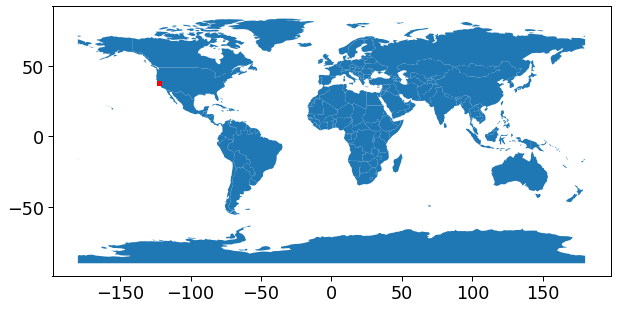

In [ ]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [ ]:
import pandas as pd
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

# Download shapefile data for SF
! wget https://www2.census.gov/geo/tiger/TIGER2017//ROADS/tl_2017_06075_roads.zip
    
# Unzip shapefiles into shapefiles folder using unzip
with zipfile.ZipFile('tl_2017_06075_roads.zip', 'r') as zip_ref:
    zip_ref.extractall('shapefiles')

--2022-08-29 17:11:06--  https://www2.census.gov/geo/tiger/TIGER2017//ROADS/tl_2017_06075_roads.zip
Resolving www2.census.gov (www2.census.gov)... 104.66.235.36, 2600:1408:10:3bc::208c, 2600:1408:10:385::208c
Connecting to www2.census.gov (www2.census.gov)|104.66.235.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘tl_2017_06075_roads.zip’

tl_2017_06075_roads     [ <=>                ] 586.77K  --.-KB/s    in 0.09s   

2022-08-29 17:11:06 (6.30 MB/s) - ‘tl_2017_06075_roads.zip’ saved [600849]



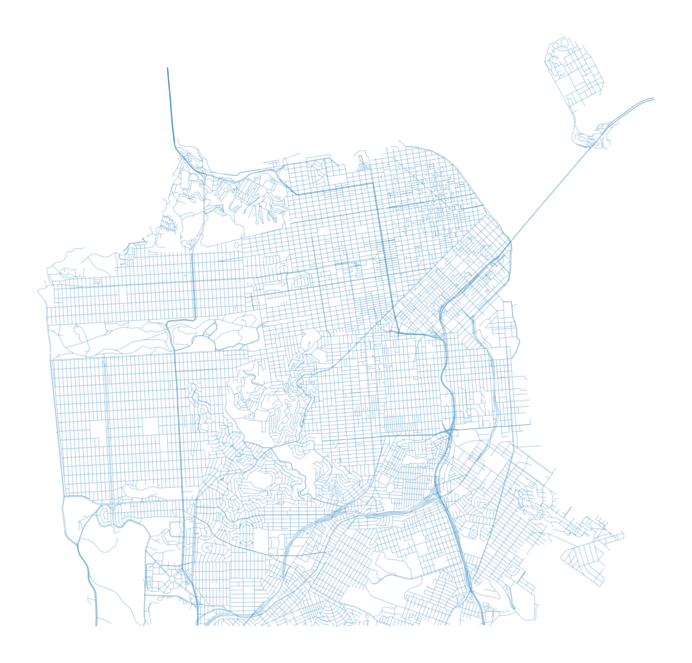

In [ ]:
geo_df = gpd.read_file('shapefiles/tl_2017_06075_roads.shp')
# Initialize our plot
fig, ax = plt.subplots(figsize=(10,10))# Plot our SF GeoDataFrame
geo_df.plot(ax=ax, alpha = .2)# Turn off axis
ax.set_axis_off()# Save image
fig.tight_layout()
plt.savefig('shapefile_plot.png');

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


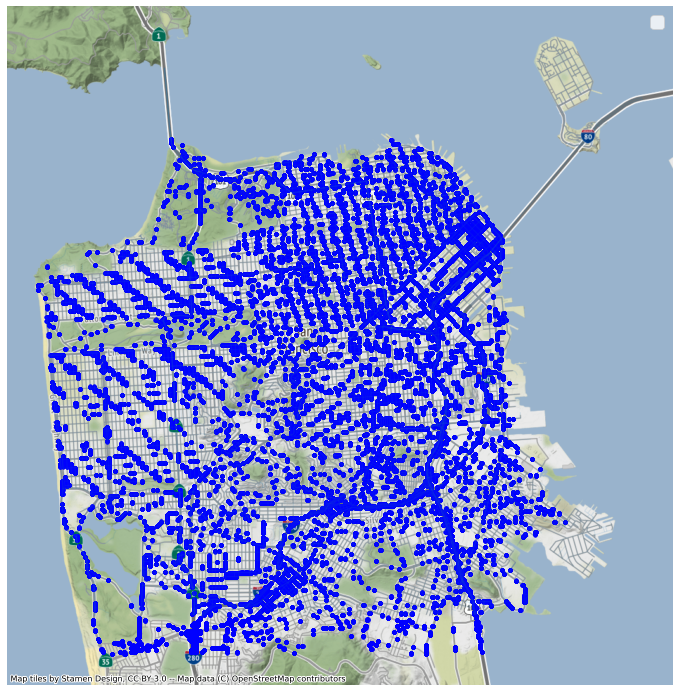

In [ ]:
geo_df = geo_df.to_crs(epsg=3857)
df['geometry'] = df.apply(lambda x: Point(float(x.Longitude), float(x.Latitude)), axis=1)# Convert Pandas DataFrame to a GeoDataFrame
sf_geo_df = gpd.GeoDataFrame(df, geometry='geometry')# Initialize crs to 4326 because that's the format of our geomtry
sf_geo_df.crs = "EPSG:4326"# Change the crs to match our SF GeoDataFrame
sf_geo_df = sf_geo_df.to_crs(epsg = 3857)

train_sf = sf_geo_df.iloc[0:59650, :]
test_db_sf = sf_geo_df.iloc[59651:86841, :]
test_qr_sf = sf_geo_df.iloc[86842:87841, :]
val_db_df = sf_geo_df.iloc[87842:95856, :]
val_qr_df = sf_geo_df.iloc[95857:103849, :]

# Change context for readability
sns.set_context("paper", font_scale=2)# Initialize our plot
fig, ax = plt.subplots(figsize=(10,10))# Plot our SF GeoDataFrame
geo_df.plot(ax=ax, alpha = .1)# Plot our Starbucks locations
train_sf.plot(ax=ax, marker = '.', markersize=50, color='blue')


ctx.add_basemap(ax)# Turn off axis
ax.set_axis_off()
fig.tight_layout()
#plt.title("Geo-location")
ax.legend(["SF-XS Train Set"])
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
plt.savefig('sanFrancisco_train.png');

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


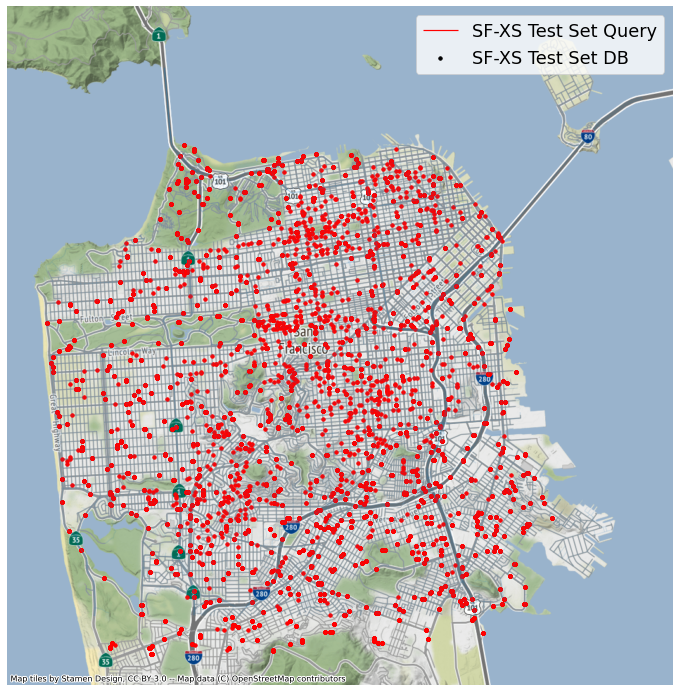

In [ ]:
geo_df = geo_df.to_crs(epsg=3857)
df['geometry'] = df.apply(lambda x: Point(float(x.Longitude), float(x.Latitude)), axis=1)# Convert Pandas DataFrame to a GeoDataFrame
sf_geo_df = gpd.GeoDataFrame(df, geometry='geometry')# Initialize crs to 4326 because that's the format of our geomtry
sf_geo_df.crs = "EPSG:4326"# Change the crs to match our SF GeoDataFrame
sf_geo_df = sf_geo_df.to_crs(epsg = 3857)

train_sf = sf_geo_df.iloc[0:59650, :]
test_db_sf = sf_geo_df.iloc[59651:86841, :]
test_qr_sf = sf_geo_df.iloc[86842:87841, :]
val_db_df = sf_geo_df.iloc[87842:95856, :]
val_qr_df = sf_geo_df.iloc[95857:103849, :]

# Change context for readability
sns.set_context("paper", font_scale=2)# Initialize our plot
fig, ax = plt.subplots(figsize=(10,10))# Plot our SF GeoDataFrame
geo_df.plot(ax=ax, alpha = .1)# Plot our Starbucks locations

test_db_sf.plot(ax=ax, marker = '.', markersize=50, color='red')
test_qr_sf.plot(ax=ax, marker = 'x', markersize=50, color='black')


ctx.add_basemap(ax)# Turn off axis
ax.set_axis_off()
fig.tight_layout()
#plt.title("Geo-location")
ax.legend(["SF-XS Test Set Query","SF-XS Test Set DB"])
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('red')
plt.savefig('sanFrancisco_test.png');

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


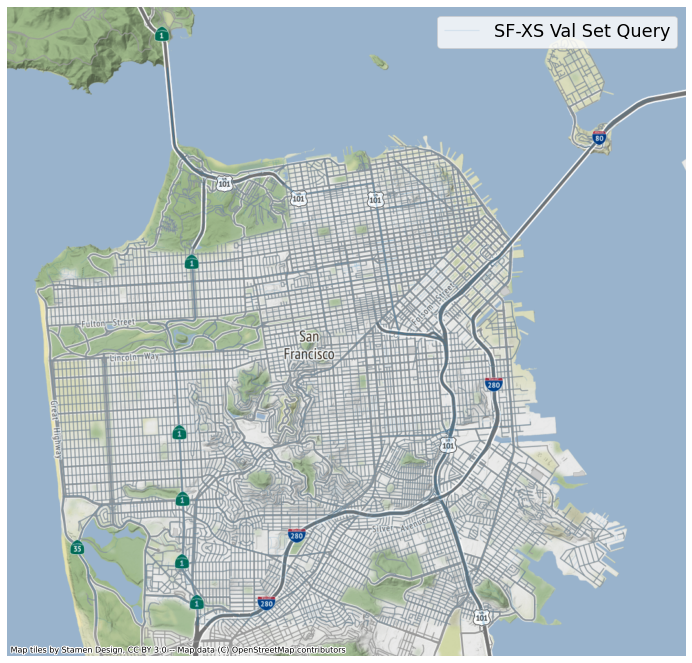

In [ ]:
geo_df = geo_df.to_crs(epsg=3857)
df['geometry'] = df.apply(lambda x: Point(float(x.Longitude), float(x.Latitude)), axis=1)# Convert Pandas DataFrame to a GeoDataFrame
sf_geo_df = gpd.GeoDataFrame(df, geometry='geometry')# Initialize crs to 4326 because that's the format of our geomtry
sf_geo_df.crs = "EPSG:4326"# Change the crs to match our SF GeoDataFrame
sf_geo_df = sf_geo_df.to_crs(epsg = 3857)

train_sf = sf_geo_df.iloc[0:59650, :]
test_db_sf = sf_geo_df.iloc[59651:86841, :]
test_qr_sf = sf_geo_df.iloc[86842:87841, :]
val_db_df = sf_geo_df.iloc[87842:95856, :]
val_qr_df = sf_geo_df.iloc[95857:103849, :]

# Change context for readability
sns.set_context("paper", font_scale=2)# Initialize our plot
fig, ax = plt.subplots(figsize=(10,10))# Plot our SF GeoDataFrame
geo_df.plot(ax=ax, alpha = .1)# Plot our Starbucks locations

val_db_df.plot(ax=ax, marker = '.', markersize=90, color='red')
val_qr_df.plot(ax=ax, marker = 'x', markersize=50, color='black')

ctx.add_basemap(ax)# Turn off axis
ax.set_axis_off()
fig.tight_layout()
#plt.title("Geo-location")
ax.legend(["SF-XS Val Set Query","SF-XS Val Set DB"])
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('red')
plt.savefig('sanFrancisco_val.png');